In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#from startup import *
import sys,os,glob
import subprocess

import matplotlib as mpl
import numpy as np
from matplotlib.colors import LogNorm,Normalize,SymLogNorm
import cmocean

### setting up for princeton-macbook system
### base directory path is /Users/ckim/Research/TIGRESS/


In [2]:
import matplotlib.pyplot as plt
# Figure
plt.rcParams['figure.figsize']=(8,6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.bbox']='tight'

# Font
plt.rcParams['font.size']=20
plt.rcParams['font.weight'] = 300

# Axes
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.width']=2
plt.rcParams['ytick.major.width']=2
plt.rcParams['xtick.major.size']=5
plt.rcParams['ytick.major.size']=5

# Line
plt.rcParams['lines.linewidth']=2

# Image
plt.rcParams['image.origin']='lower'

In [119]:
def texteffect(fontsize=12):
    try:
        from matplotlib.patheffects import withStroke
        myeffect = withStroke(foreground="w", linewidth=3)
        kwargs = dict(path_effects=[myeffect], fontsize=fontsize)
    except ImportError:
        kwargs = dict(fontsize=fontsize)
    return kwargs

In [4]:
# %load obtain_mvz.py
import yt
from yt import derived_field
from yt.units.unit_object import Unit
from yt.units import kpc, pc, kboltz, mh
import numpy as np
import sys
import matplotlib.pyplot as plt
from math import *

sys.path.insert(0,'../python/')
import cooling
cf=cooling.coolftn()

#def _temp(field, data):
#    return  (mh*data['gas',"pressure"]/data['gas',"density"]/kboltz)

def _T1(field, data):
        return data["gas","pressure"]/data["gas","density"]*mh/kboltz

def _mu(field, data):
        T1=data["gas","T1"].d
        temp=cf.get_temp(T1)
        return temp/T1

def _temperature(field,data):
        return data["gas","T1"]*data["gas","mu"]
    
def _vout(field,data):
        return data["gas","velocity_z"]*data['z']/abs(data['z'])
    
yt.add_field(("gas", "T1"), function=_T1, units='K')
yt.add_field(("gas", "mu"), function=_mu, units='')
yt.add_field(("gas", "temperature"), function=_temperature, units='K')
yt.add_field(("gas", "vout"), function=_vout, units='km/s')

unit_base={"length_unit": (1.0,"pc"),
           "time_unit": (1.0,"s*pc/km"),
           "mass_unit": (2.38858753789e-24,"g/cm**3*pc**3"),
           "velocity_unit": (1.0,"km/s"),
           "magnetic_unit": (5.4786746797e-07,"gauss")}
tigress_unit_system=yt.UnitSystem('tigress','pc','Msun','Myr',)
tigress_unit_system['velocity']='km/s'
tigress_unit_system['magnetic_field']='uG'



/Users/ckim/miniconda3/lib/python3.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [132]:
from pyathena.set_plt import toggle_yticks,toggle_xticks
plt.rcParams['font.size']=16
def pdf_plot(pdf,xbin,ybin,label='Mass Fraction'):
    fig,axes=plt.subplots(2,2,sharex=False, sharey=False, 
                          gridspec_kw={'hspace':0,'wspace':0,'width_ratios':[2,1],'height_ratios':[2,1]})
    ax=axes[0,0]

    im=ax.pcolormesh(xbin,ybin,pdf,norm=LogNorm(),rasterized=True)
    im.set_clim(5.e-9,5.e-2)
    im.set_cmap('cubehelix_r')
    ax.set_xscale('log')
    ax.set_ylim(-250,550)
    ax.set_xlim(10,1.e8)
    ax.set_ylabel(r'$v_{\rm out}$ [km/s]')
    toggle_xticks([ax])
    for t0 in [184,5050,2.e4,5.e5]:
        ax.axvline(t0,ls=':')

    ax=axes[1,0]
    ax.step(xbin[1:],pdf.sum(axis=0))
    outflow = ybin[1:] > 50
    
    ax.step(xbin[1:],pdf[outflow,:].sum(axis=0),color='C6',label=r'$v_{\rm out}>50\,{\rm km/s}$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10,1.e8)
    ax.set_ylim(1.e-8,1.e-1)
    #ax.set_ylabel('Mass Fraction')
    ax.set_xlabel('T [K]')
    for t0 in [184,5050,2.e4,5.e5]:
        ax.axvline(t0,ls=':')

    ax=axes[0,1]
    
    ax.step(pdf.sum(axis=1),ybin[1:])
    
    warm=xbin[1:]<2.e4
    inter=(xbin[1:]>2.e4) & (xbin[1:]<5.e5)
    hot=xbin[1:]>5.e5
    ax.step(pdf[:,warm].sum(axis=1),ybin[1:],color='C2',label='warm')
    ax.step(pdf[:,inter].sum(axis=1),ybin[1:],color='C1',label='intermediate')
    ax.step(pdf[:,hot].sum(axis=1),ybin[1:],color='C3',label='hot')

    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylim(-250,550)
    ax.set_xlim(1.e-8,1.e-1)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    ax.set_xticks([1.e-7,1.e-4,1.e-1])
    #ax.set_xlabel('Mass Fraction')
    toggle_yticks([ax])

    axes[1,1].axis('off')
    plt.tight_layout()

    ax=axes[0,0]
    x0,y0,xl,yl=ax.get_position().bounds
    cax=fig.add_axes([x0,y0+yl,xl,0.02])
    cbar=fig.colorbar(im,cax=cax,label=label,orientation='horizontal')
    cax.xaxis.tick_top()
    cax.xaxis.set_label_position('top')

    return fig

In [8]:
filename = '../data/MHD_4pc_new_joined.0450.vtk'

In [9]:
ds = yt.load(filename, units_override=unit_base, unit_system=tigress_unit_system)

yt : [INFO     ] 2019-05-22 16:08:47,152 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-05-22 16:08:47,154 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-05-22 16:08:47,154 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-05-22 16:08:47,155 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-05-22 16:08:47,157 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-05-22 16:08:47,159 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-05-22 16:08:47,160 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-05-22 16:08:47,186 Parameters: current_time              = 450.0002
yt : [INFO     ] 2019-05-22 16:08:47,187 Parameters: domain_dimensions         = [ 256  256 1792]
yt : [INFO     ] 2019-05-22 16:08:47,188 Parameters: domain_left_edge          = [ -512.  -512. 

# PDF calculations and figures

In [17]:
data=ds.all_data()
cut_mid = data.cut_region(['(obj["z"]<=500) & (obj["z"]>=-500)']) 
cut_z1  = data.cut_region(['(abs(obj["z"])>500) & (abs(obj["z"])<1000)']) 
cut_z2  = data.cut_region(['(abs(obj["z"])>=1000)']) 
#cut_hot  = data.cut_region(['(obj["temperature"]>=0.5e6)']) 


In [18]:
mtot,tmp=data.quantities.total_mass()
vtot=data.quantities.total_quantity(['cell_volume'])

In [19]:
pdfs=[]
for region in [cut_mid,cut_z1,cut_z2]:
    pdf = yt.create_profile(region,['temperature','vout'],fields=['cell_mass','cell_volume'],
                       extrema={'temperature':(10,1.e8),'vout':(-1000,1000)},
                       n_bins=(350,250),logs={'temperature':True,'vout':False},
                       weight_field=None,fractional=False, units={'temperature':'K','vout':"km/s"})
    pdfs.append(pdf)

In [20]:
mf=[]
vf=[]
for pdf in pdfs:
    mf.append(pdf.field_data[('gas','cell_mass')]/mtot)
    vf.append(pdf.field_data[('gas','cell_volume')]/vtot)

In [21]:
for mf_,vf_,ph in zip(mf,vf,['mid','z1','z2']):
    print(ph,mf_.sum(),vf_.sum())
print(np.sum(mf),np.sum(vf))

mid 0.9114202592240999 dimensionless 0.13950863906315394 dimensionless
z1 0.057093235114416926 dimensionless 0.1395089030265808 dimensionless
z2 0.03141513741429897 dimensionless 0.7209821343421937 dimensionless
0.9999286317528159 0.9999996764319283


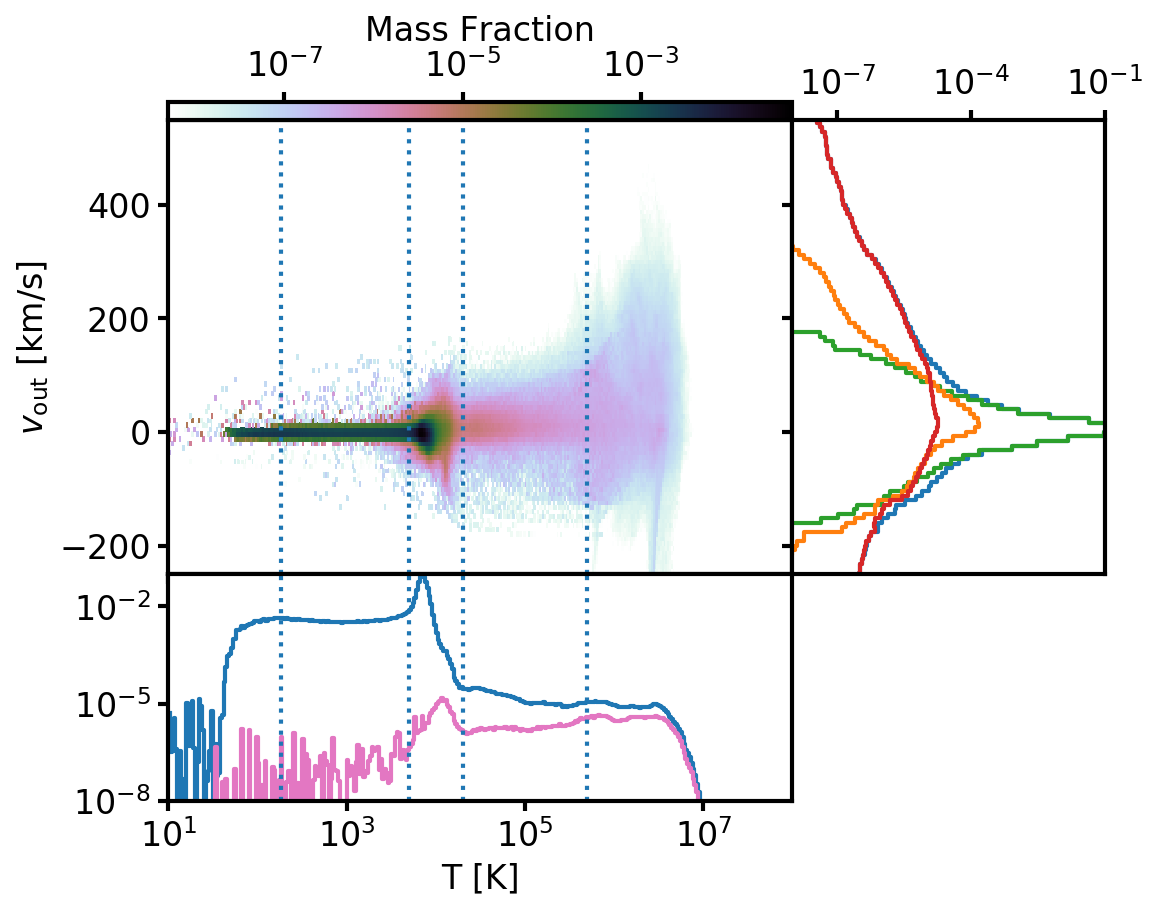

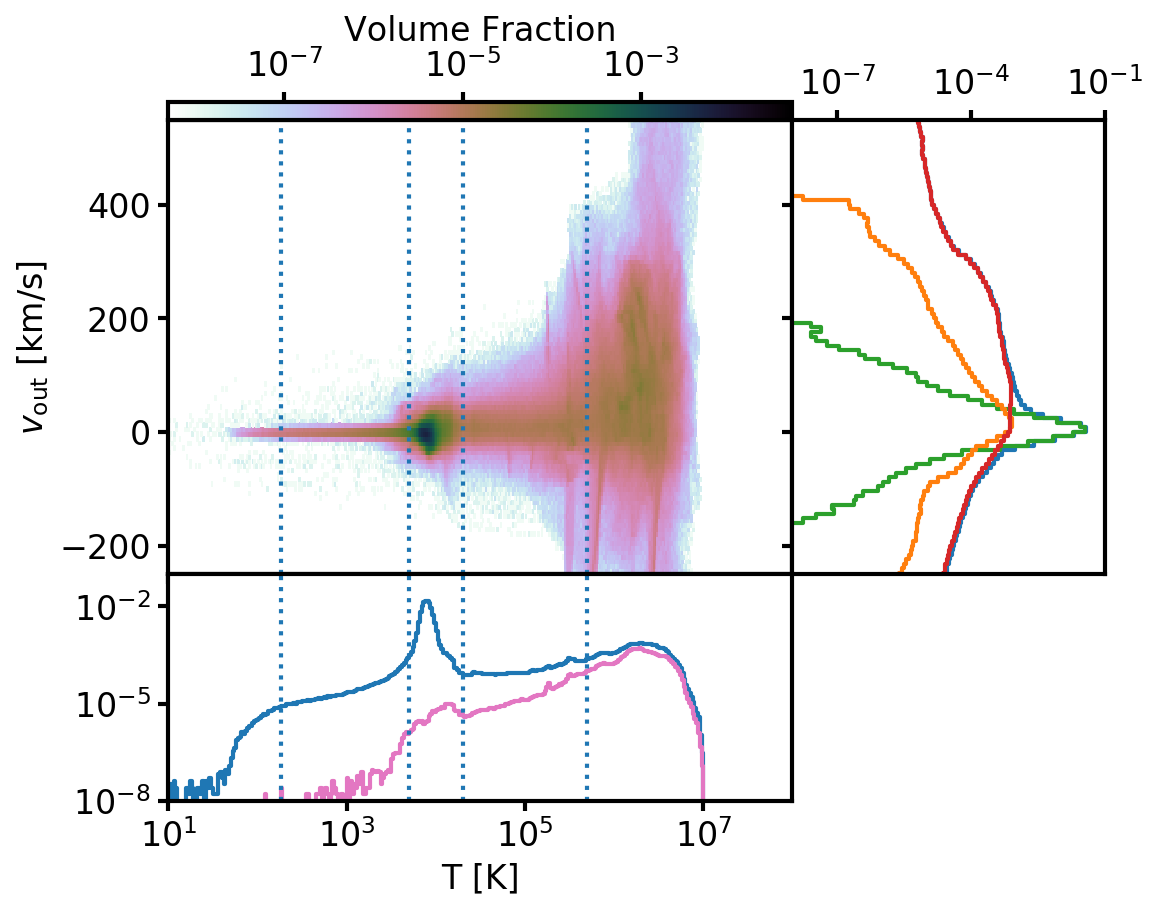

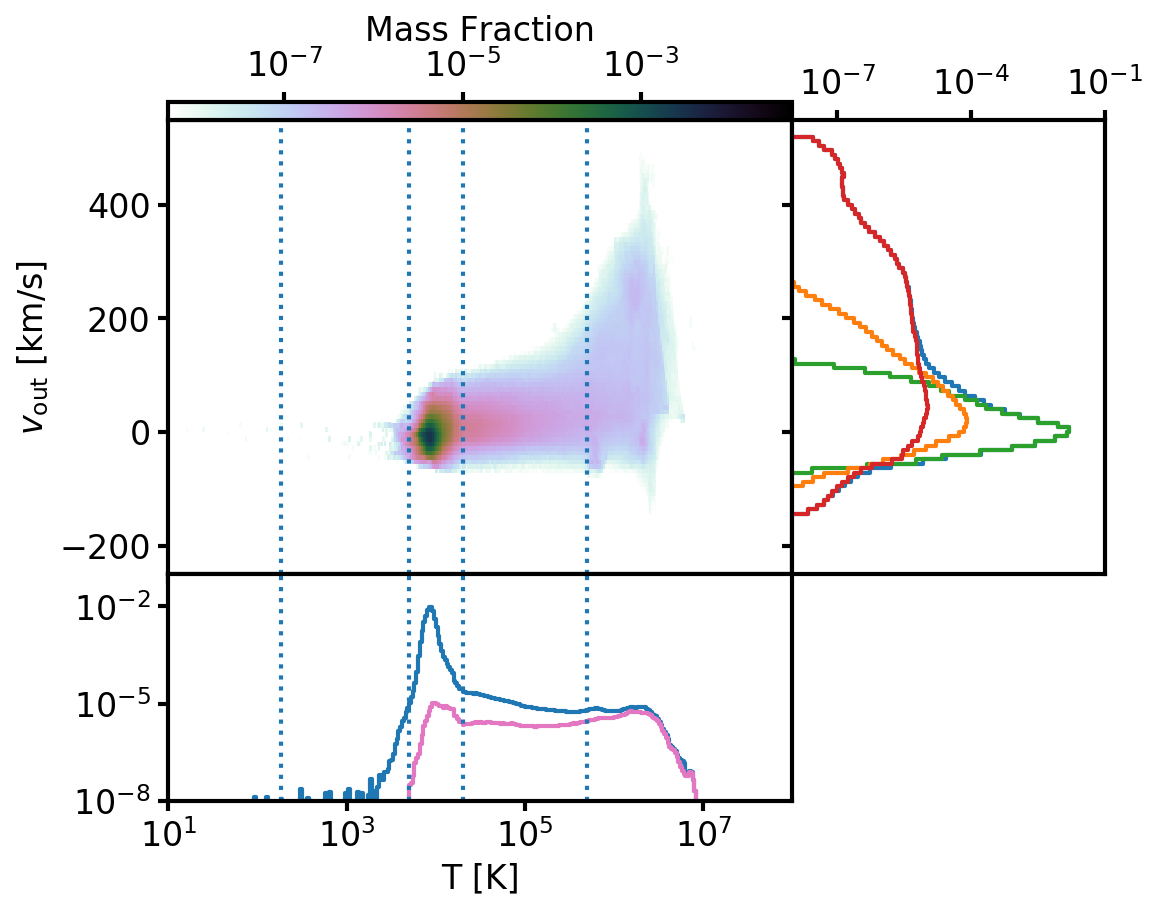

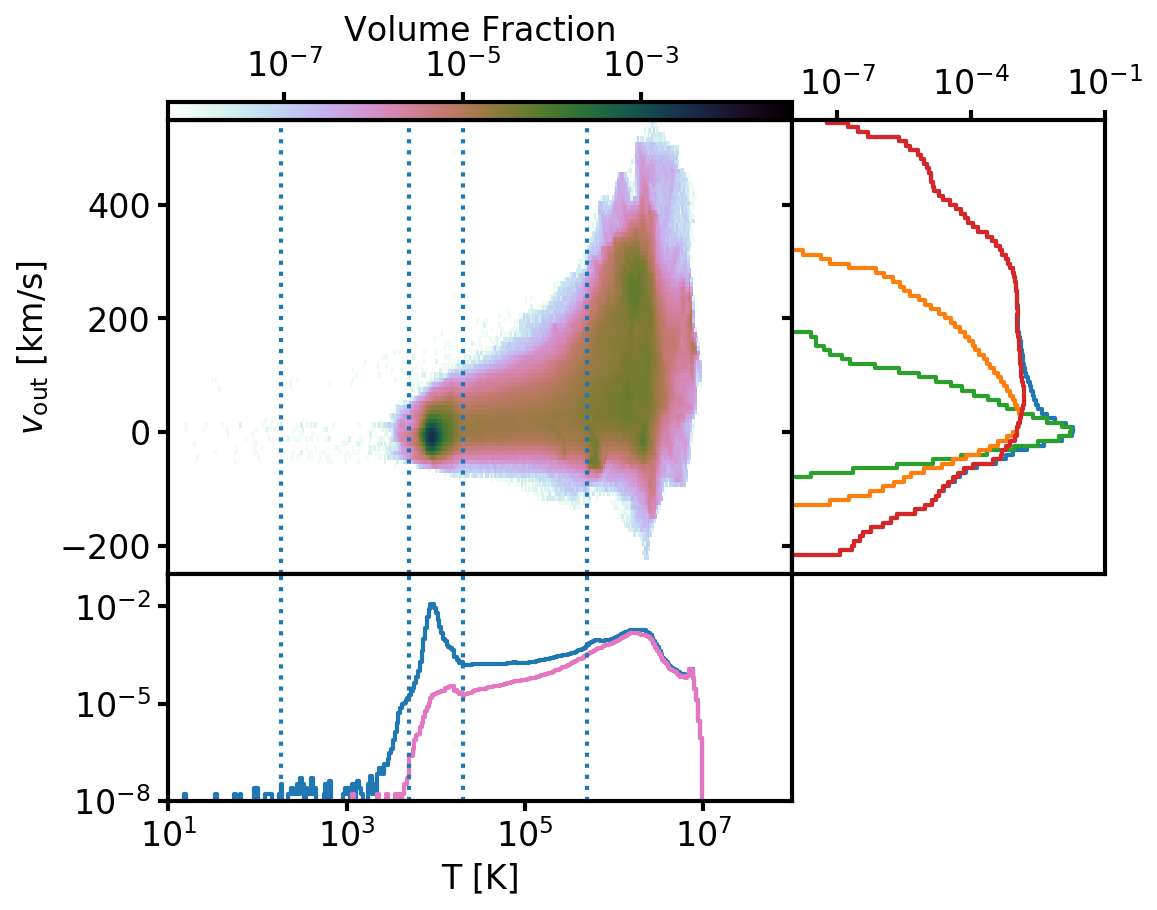

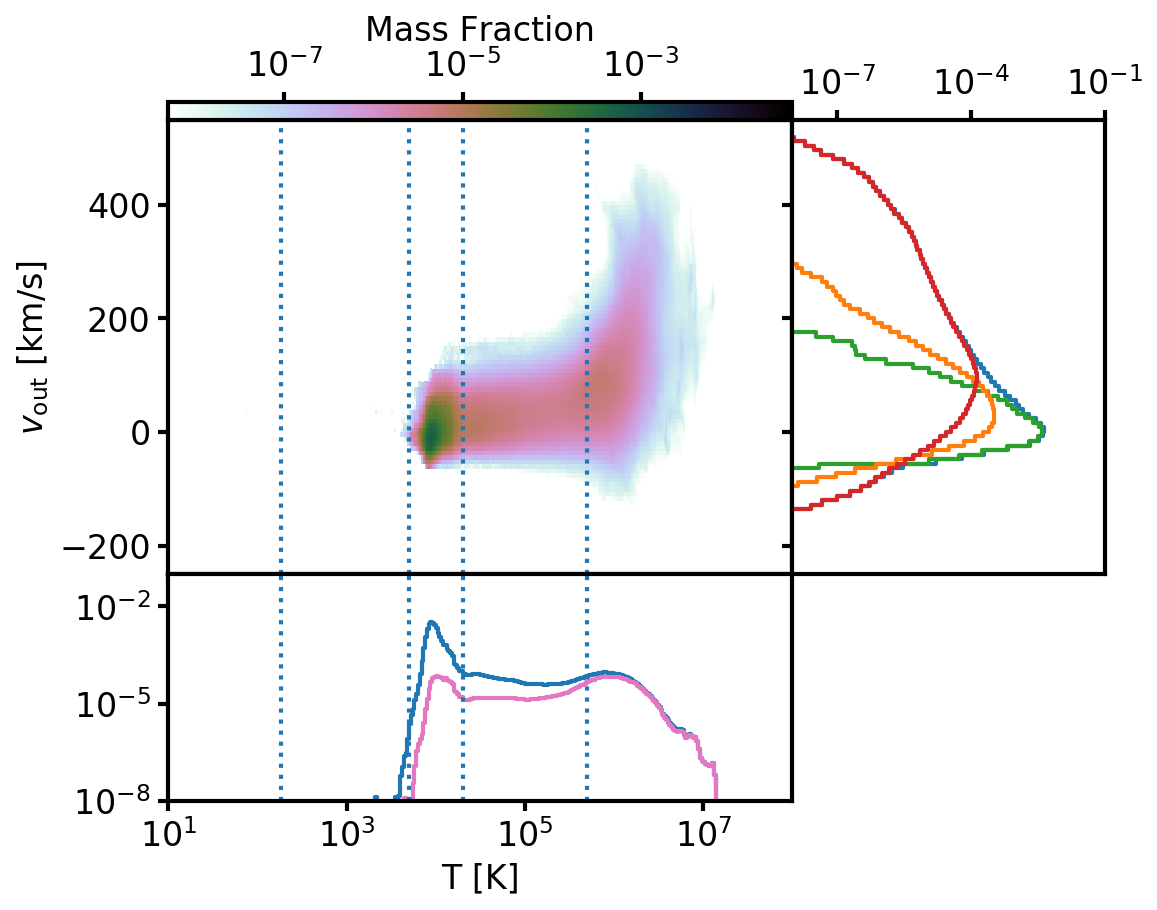

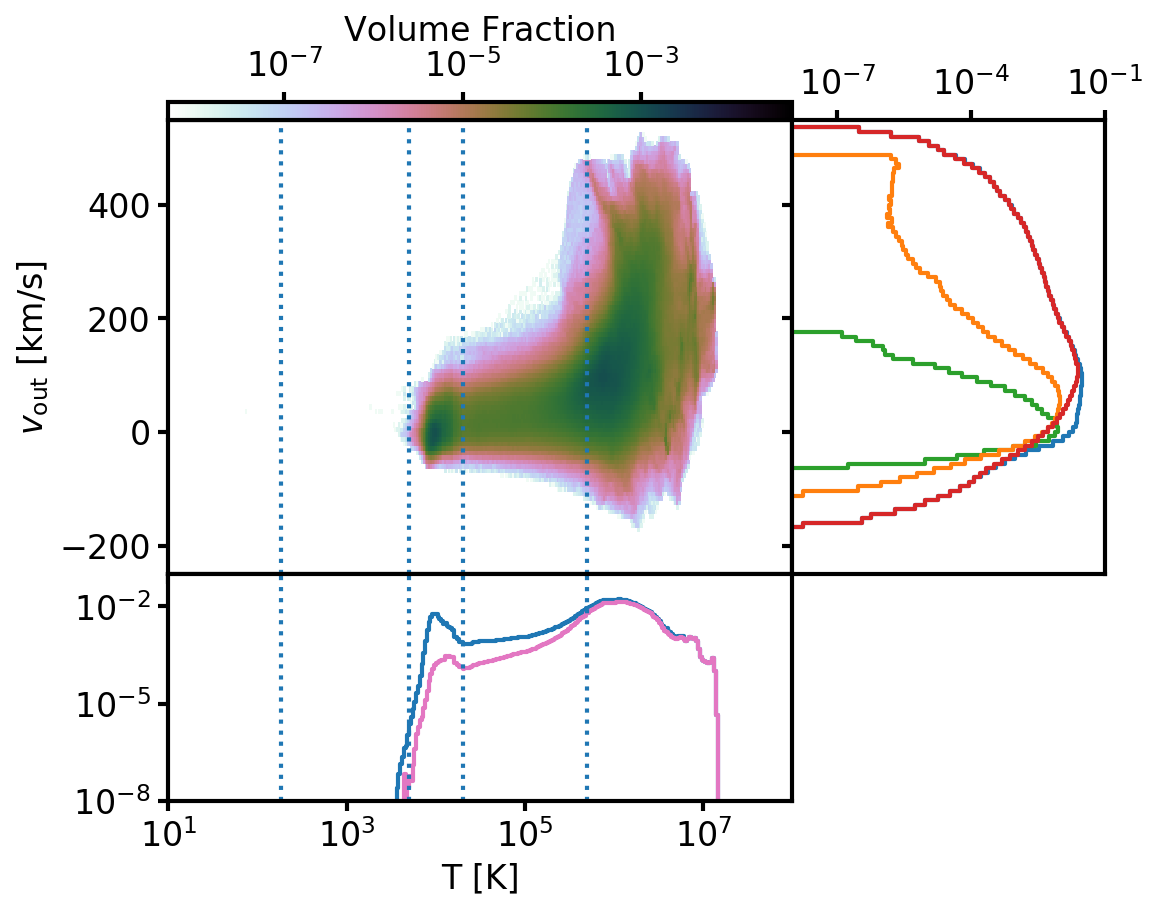

In [23]:
for mf_,vf_,pdf,ph in zip(mf,vf,pdfs,['mid','z1','z2']):
    xbin=pdf.x_bins.v
    ybin=pdf.y_bins.v
    fig1=pdf_plot(mf_.v.T,xbin,ybin,'Mass Fraction')
    fig1.savefig('../supplement/pdfs_{}_{}.png'.format('mass',ph))
    fig2=pdf_plot(vf_.v.T,xbin,ybin,'Volume Fraction')
    fig2.savefig('../supplement/pdfs_{}_{}.png'.format('vol',ph))

# Figure: mass weighted PDF of region z>1kpc

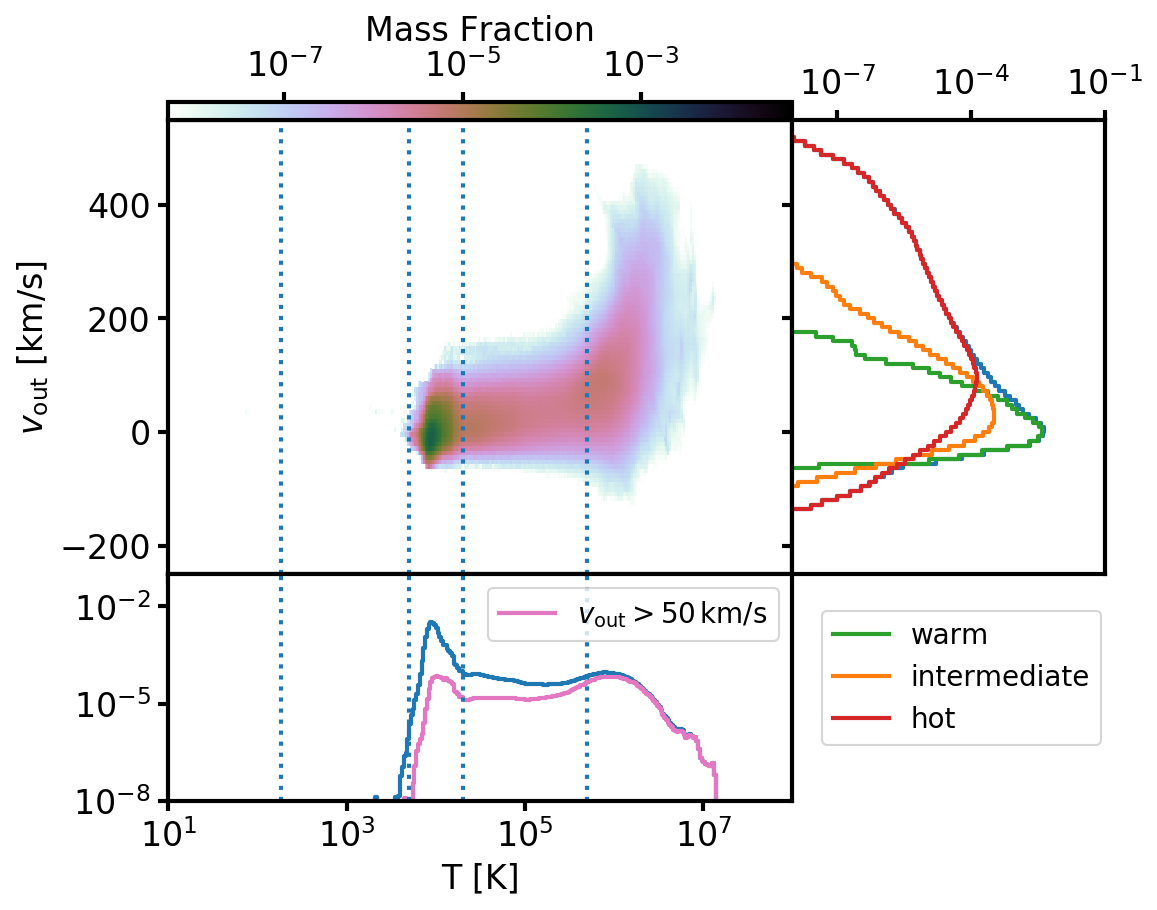

In [139]:
fig=pdf_plot((mf[2]).v.T,pdfs[1].x_bins.v,pdfs[1].y_bins.v)
axes=fig.axes
axes[1].legend(fontsize='small',loc='upper left',bbox_to_anchor=(0.05,-0.05))
axes[2].legend(fontsize='small')

outdir='../figures/'

# fig.savefig('{}/pdfs.png'.format(outdir))
fig.savefig('{}/pdfs.pdf'.format(outdir),bbox_inches='tight',dpi=150)

# Slices

In [137]:
def plot_slices(fig,ds,x0):
    slc=ds.slice('x',x0)
    Nx,Ny,Nz=ds.domain_dimensions
    xmin,ymin,zmin=ds.domain_left_edge.v/1.e3
    xmax,ymax,zmax=ds.domain_right_edge.v/1.e3
    y=slc['y'].reshape(Ny,Nz).v[:,0]/1.e3
    z=slc['z'].reshape(Ny,Nz).v[0,:]/1.e3
    nslice=slc[('athena','density')].reshape(Ny,Nz).v.T
    Tslice=slc['temperature'].reshape(Ny,Nz).v.T
    vx=slc[('athena','velocity_y')].reshape(Ny,Nz).v.T
    vy=slc[('athena','velocity_z')].reshape(Ny,Nz).v.T
    xextent=[ymin,ymax,zmin,zmax]
    
    plt.rcParams['font.size']=16
    from mpl_toolkits.axes_grid1 import ImageGrid
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 2),
                     axes_pad=0.2,
                     add_all=True,
                     label_mode="L",
                     cbar_mode="each",
                     cbar_location='top',
                    )
    im1=grid[0].imshow(nslice,norm=LogNorm(),origin='lower',
               clim=(5.e-5,1),cmap=plt.cm.bone_r,extent=xextent)
    Nskip=8
    vvec=grid[0].quiver(y[::Nskip],z[::Nskip],
                           vx[::Nskip,::Nskip],vy[::Nskip,::Nskip],scale=3000)
    grid[0].quiverkey(vvec, X=-0.4, Y=3.04, U=200,label='',coordinates='data')
    grid[0].text(-0.3,3.04,'v=200km/s',va='center',fontsize=10)

    im2=grid[1].imshow(Tslice,norm=LogNorm(),origin='lower',
               clim=(5000,1.e7),cmap=plt.cm.RdYlGn_r,extent=xextent)

    cb1=plt.colorbar(im1,cax=grid[0].cax,orientation='horizontal')
    cb1.set_label(r'Number Density [${\rm cm^{-3}}$]',fontsize='small')
    cb2=plt.colorbar(im2,cax=grid[1].cax,orientation='horizontal')
    cb2.set_label(r'Temperature [$K$]',fontsize='small')
    for g in grid:
        g.set_ylim(1,3)
        g.cax.xaxis.tick_top()
        g.cax.xaxis.set_label_position('top')
        g.cax.tick_params(labelsize='small')
    grid[0].set_xlabel('x [kpc]')
    grid[0].set_ylabel('z [kpc]')
    grid[0].set_yticks([1,1.5,2,2.5,3])
    grid[1].plot([0.2,0.4],[2.85,2.85],lw=4,color='k')


    grid[1].text(0.3,2.9,'200 pc',ha='center',**texteffect())
    grid[1].set_xticklabels('')
    return fig

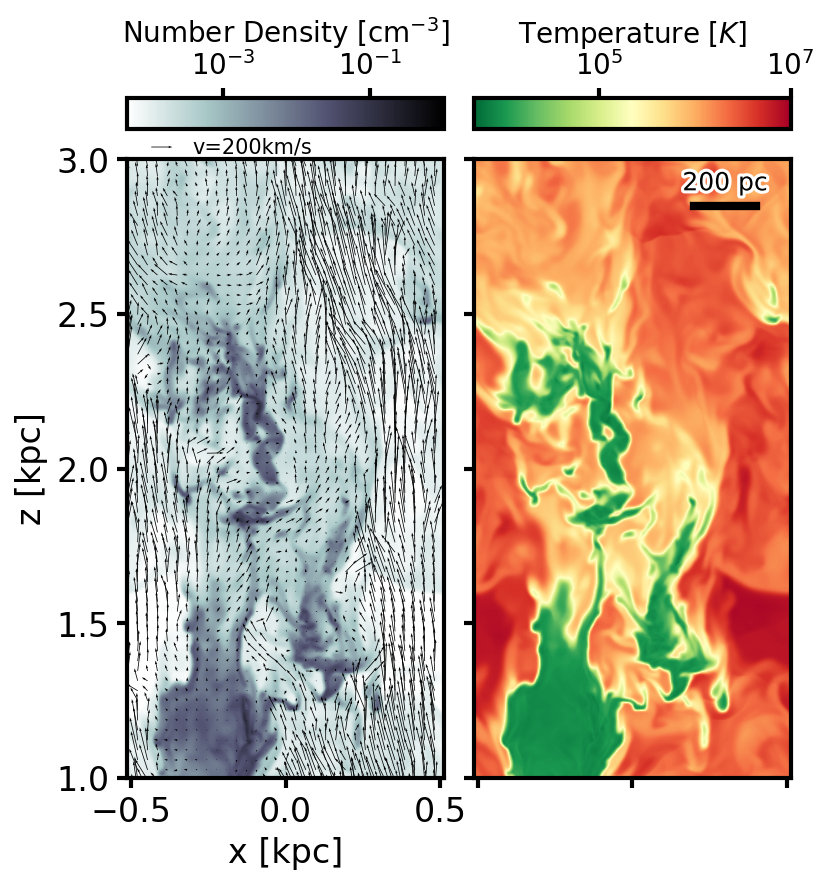

In [138]:
plt.rcParams['image.interpolation']='bilinear'
fig=plot_slices(plt.figure(),ds,140)
fig.savefig('../figures/slices_nH_T.pdf',bbox_inches='tight',dpi=150)
# fig.savefig('../figures/slices_nH_T.png',bbox_inches='tight',dpi=150)